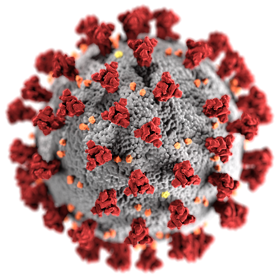

# Türkiye il bazlı COVID-19 korelasyon analizi

- **Amaç:** Türkiye'deki il bazlı COVID-19 vaka sayısının, her ilin demografik verileri (eğitim, ticari, vb.) ile olan ilişkilerini basit korelasyon analizi ile incelemek

- **Kullanılan veri setleri:** 3 Nisan itibariyle açıklanan Türkiye il bazlı vaka sayıları, TÜİK veri setleri

- **Bulgular:** Her il için seçilen veriler arasından, her 1000 kişide görülen COVID-19 vaka sayısı ile en güçlü ilişkinin bir ildeki nüfus yoğunluğu olduğu, diğer faktörler ile vaka sayısı arasında istatiksel olarak güçlü bir ilişki olmadığı görülmüştür. Bu açıdan birim alandaki kişi sayısının en aza indirilmesinin önemi, yani sosyal mesafenin korunması istatistiksel açıdan da kanıtlanmaktadır

**NOTLAR**
- Analiz açıklanan vaka sayıları ile bağlantılı olup nüfusu 750.000'den fazla olan illeri kapsamaktadır. Diğer iller vaka sayılarının görece az olması ve analizde uç değer oluşturmaları sebebiyle korelasyon analizine dahil edilmemiştir
- Yeni vaka sayılarının açıklanması ile beraber analiz güncellenecektir

# Veri manipülasyonu

TÜİK'ten alınan il bazlı veriler ve cevaplamaya çalıştığım sorular:

* **Ortalama hanehalkı büyüklüğü** (hanehalkı büyüklüğü arttıkça vaka sayısı artıyor mu?)
* **Nüfus** (1000 kişi başına hesaplamalarda kullanılacak)
* **Okuma yazma oranı** (Okuma yazma düzeyi arttıkça vaka sayısı artıyor mu?)
* **Ölüm sayısı** (2019 yılı içerisinde hayatını kaybeden nüfus) (Geçmiş yıllardaki ölüm sayısı ile vaka sayısı arasında ilişki var mı?)
* **Otomobil sayısı** (Mobilite düzeyi arttıkça vaka sayısı artıyor/azalıyor mu?)
* **Kişi başına düşen milli gelir (USD)** (Ortalama GSYH ile vaka sayısı arasında bir ilişki var mı?)
* **100 bin kişi başına düşen yatak sayısı & hastane sayısı ** (Bakım /vaka tespit imkanları ile vaka sayısı arasında bir ilişki  var mı?)
* **Nüfus yoğunluğu** (birim alan başına düşen nüfus ile vaka sayısı arasında bir ilişki var mı?)

TÜİK verilerini içeren veri seti:

In [ ]:
# Library'lerin yüklenmesi
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import unidecode
import math
unidecode.unidecode('İ,Ö,Ü,Ş,Ç,Ğ,ı,ö,ü,ş,ç,ğ')
from scipy.stats.stats import pearsonr

# Veri dosyalarının yüklenmesi
df = pd.read_excel('../input/il-bazli-veri-220420/agg.xlsx')
df2 = pd.read_csv('../input/number-of-cases-in-the-city-covid19-turkey/number_of_cases_in_the_city.csv')

# Veri setlerinin kopyalanması
ilbazlimetrik = df
sehir_covid = df2

# Veri setlerine hızlı bir bakış
ilbazlimetrik.head()

Şehir bazlı vaka sayılarını içeren veri seti:

In [ ]:
# Veri setlerine hızlı bir bakış
sehir_covid.head()

In [ ]:
# Veri setinin manipülasyonu
ilbazlimetrik = ilbazlimetrik[ilbazlimetrik['Sehir']!="Turkiye"]
sehir_covid = sehir_covid[['Province','Number of Case']]
ilbazlimetrik['Sehir']=ilbazlimetrik['Sehir'].apply(lambda x: unidecode.unidecode(x))

# Tabloların birleştirilmesi
agg = pd.merge(ilbazlimetrik,sehir_covid,'left',left_on=ilbazlimetrik['Sehir'],right_on=sehir_covid['Province'])
agg = agg.drop(['Province','Sehir'],axis=1)

İki veri setini birleştirmemizle ortaya çıkan veri seti:

In [ ]:
# Birleştirilen tablolara göz atılması
agg.head()

Korelasyon analizi için bütün verileri aynı düzleme getirmek için bütün verileri bin kişi başına olacak şekilde tekrar hesapladım. Ardından okuma yazma için ise neredeyse bütün iller %96 üzerinde skora sahip olduğu için veriyi normalize ederek illere en az okuma oranına sahip il 0, en yükseği ise 100 olacak şekilde tekrar skorlama yaptım. 

Ardından yeni veri setimde nüfusu 750.000'den fazla illeri analize dahil ettim (diğer illerdeki vaka sayısı azlığı ve bütün populasyonun yeterli olarak yansıtılmadığı varsayımı ile)

In [ ]:
# Yeni tablodaki hesaplamaların yapılması
agg['Olum_sayisi_binkisi']= agg['Olum_sayisi']/agg['Nufus']*1000
agg['Otomobil_sayisi_binkisi']=agg['Otomobil_sayisi']/agg['Nufus']*1000
agg['Hastane_binkisibasi']=agg['Toplam_hastane']/agg['Nufus']*1000
agg['Okuma_yazma_skor']=(agg['Okuma_yazma']-agg['Okuma_yazma'].min())/(agg['Okuma_yazma'].max()-agg['Okuma_yazma'].min())*100
agg['Vaka_binkisi'] = agg['Number of Case']/agg['Nufus']*1000
agg['Yatak_binkisibasi']=agg['Yatak_100binkisi']/100

# Nüfusa göre 750.000'den büyük illerin analize dahil edilmesi
agg2 = agg[agg['Nufus']>750000]
agg2 = agg2.drop(['Nufus','Okuma_yazma','Olum_sayisi','Otomobil_sayisi','Toplam_hanehalki','Toplam_hastane','Number of Case','Yatak_100binkisi'],axis=1)
agg2 = agg2.rename(columns={'key_0':'Sehir'})

Yeni veri seti aşağıdaki gibi oluştu, analizimiz 750.000'den fazla nüfusu olan toplamda 30 ili kapsayacak

In [ ]:
agg2.head()

# Keşifsel veri analizi
Bin kişi başı görülen vaka sayısına göre illeri sıraladığımızda, İstanbul'un yüksek nufüsuna rağmen vaka sayısının da diğer illerin çok üstünde olmasıyla **1. sırada olduğunu** ve bin kişi başına göre **2. sıradaki Sakarya'nın iki katından fazla vakaya sahip olduğunu** görüyoruz. 

İkinci grupta ise **Sakarya, Konya, Kocaeli ve İzmir**'in geri kalan illere kıyasla bin kişi başına diğer illerden gözle görülür biçimde **daha fazla vakaya** sahip olduğunu görüyoruz.

In [ ]:
# Son tabloyla ilgili bir kaç grafik (il bazlı toplam 1000 kişi başı görülen vaka sayısı, nufus yogunluk)
plt.figure(figsize=(15,5))
plt.xticks(rotation=45)
sns.barplot(x='Sehir',y='Vaka_binkisi',data=agg2.sort_values('Vaka_binkisi',ascending=False),palette='RdBu')

# Korelasyon analizi
İlk gözlemimizden sonra aşağıdaki korelasyon matrisimizi oluşturuyoruz. İstatiksel olarak, korelasyon katsayıları ve anlamları şu şekilde açıklanabilir:

* -1: Tam negatif korelasyon
* -1 ile -0.7 arasında: Güçlü negatif korelasyon
* -0.7 ile -0.5 arasında: Orta derece negatif korelasyon
* -0.5 ile -0.3 arasında: Zayıf negatif korelasyon
* -0.3 ile 0.3 arasında: Korelasyon yok
* 0.3 ile 0.5 arasında: Zayıf pozitif korelasyon
* 0.5 ile 0.7 arasında: Orta derece pozitif korelasyon
* 0.7 ile 1 arasında: Güçlü pozitif korelasyon
* 1: Tam pozitif korelasyon


In [ ]:
corrMatrix = agg2.corr('pearson')
mask = np.triu(np.ones_like(corrMatrix, dtype=np.bool))
plt.figure(figsize=(15,10))
sns.heatmap(corrMatrix,annot=True, mask=mask, cmap='coolwarm',center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

* Yukarıdaki korelasyon matrisine göre, bin kişi başına görülen vaka sayısı (*Vaka_binkisi*) ile en güçlü korelasyonun **0.86** ile nüfus yoğunluğunun (Nufus_Yogunluk) arasında olduğunu görüyoruz. Bu demek oluyor ki, her ilde her bin kişide görülen **vaka sayısı** ile o ilin **nüfus yoğunluğu** arasında **güçlü bir ilişki mevcuttur**

* İstatistiksel olarak baktığımızda, birim başına düşen insan sayısının virüsün yayılma hızında oldukça güçlü bir etken olduğunu da bu şekilde kanıtlamış oluyor ve sosyal mesafeyi korumanın önemini anlıyoruz

* Bin kişi başına görülen vaka sayısı ile diğer metriklerin ilişkisine baktığımızda ise, o ilde ** kişi başına düşen GSYH miktarı** ile vaka sayısı arasında **orta düzeyde güçlü bir ilişki** görüyoruz. Ortalama kişi başı GSYH'ı o ildeki kişi başı maddi faaliyetlerin yoğunluğu olarak kabul edersek, istatiksel olarak **0.64** korelasyon katsayısı lineer olarak güçlü kabul edilmese de, her ilde bin kişi başı görülen **vaka sayısı** ile o şehrin kişi başına düşen **maddi faaliyetleri** arasında orta düzeyde güçlü bir ilişki olduğunu söyleyebiliriz

* Bin kişi başına görülen vaka sayısı ile diğer metrikler arasında ise herhangi bir şekilde bir **korelasyon ilişkisi görmüyoruz**

# Sonuç

**Özet:** 
* Elimizde TÜİK ve Sağlık Bakanlığı tarafından açıklanan verilere göre yaptığımız analizde, il bazlı sonuçlara baktığımızda her ilde **bin kişi başına görülen vaka sayısının ** beklenileceği üzere o ildeki birim alan başına düşen nüfus ile, yani **nüfus yoğunluğuyla güçlü bir ilişkide** olduğunu görüyoruz

* Gerek il bazlı açıklanan vaka sayılarının bu çalışmanın yapıldığı tarihten 3 hafta önce olması, gerekse bu sayıların henüz erken aşama diyebileceğimiz hastalığın ilk görüldüğü günden 3 hafta sonra olması sebebiyle verilerin ve analizin doğruluğu yeni açıklanacak verilerle değişebilecek ve diğer unsurlarla vaka sayıları arasında da ilişki çıkabilecektir